In [105]:
from math import sin, cos, pi, sqrt, e, log, isclose, exp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm, pyplot as plt

import h5py
from scipy.constants import epsilon_0, mu_0
import scipy.constants

import Levenshtein as lev
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from fdtd_PCB_extensions.tissue import cole_cole_4, complex_permittivity_to_er_and_sigma, electric_field_penetration_depth

from mpl_toolkits.mplot3d import Axes3D



In [106]:
tissue_properties_database_file = '../biology/FDTD/itis_tissue_properties/SEMCAD_v14.8.h5'

tissue_obj = 0
f = h5py.File(tissue_properties_database_file,'r')
#Fuzzy matching names - keep a close eye on this, errors could creep in!
virtprop_name = "Lung"
matching_name = process.extractOne(virtprop_name,f['Tissues'].keys())
print(f"Fuzzy-matched tissue {virtprop_name} to {matching_name[0]}")

tissue_obj = f['Tissues'][matching_name[0]]


taus = np.array([0]*4,dtype=np.float)
alphas = np.array([0]*4,dtype=np.float)
deltas = np.array([0]*4,dtype=np.float)

taus[0] = tissue_obj.attrs["tau1"]
taus[1] = tissue_obj.attrs["tau2"]
taus[2] = tissue_obj.attrs["tau3"]
taus[3] = tissue_obj.attrs["tau4"]

# Tau values in the tissueprop files are normalized
# Tau1 is normalized by 1e-12
# tau2 1e-9
# tau3 1e-6
# tau4 1e-3
tau_normalization_factors = np.array([1e-12, 1e-9, 1e-6, 1e-3])
# all other constants are not normalized.
taus *= tau_normalization_factors

alphas[0] = tissue_obj.attrs["alf1"]
alphas[1] = tissue_obj.attrs["alf2"]
alphas[2] = tissue_obj.attrs["alf3"]
alphas[3] = tissue_obj.attrs["alf4"]

deltas[0] = tissue_obj.attrs["del1"]
deltas[1] = tissue_obj.attrs["del2"]
deltas[2] = tissue_obj.attrs["del3"]
deltas[3] = tissue_obj.attrs["del4"]

sigma = tissue_obj.attrs["sig"]
ef = tissue_obj.attrs["ef"]



Fuzzy-matched tissue Lung to Lung


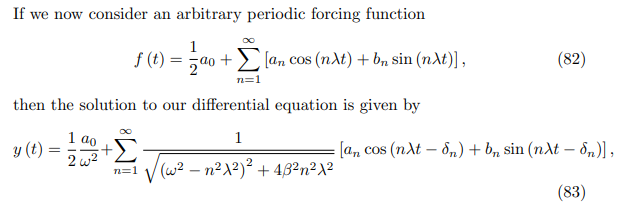


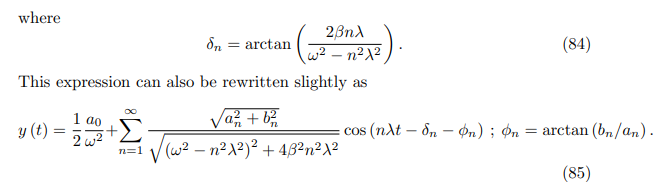

In [107]:
def fourier_amplitude_coefficients(fundamental_period, pulse_duration, N):
    # https://lpsa.swarthmore.edu/Fourier/Series/ExFS.html#EvenPulse

    n = np.arange(1, N+1)
    a_n = 2.0*(1.0/(n*pi))*np.sin(n*pi*(pulse_duration / fundamental_period))

#     a_n = np.insert(a_n, 0, (pulse_duration / fundamental_period))
    
    return a_n

fourier_amplitude_coefficients(2, 1, 7) #verified


array([ 6.366198e-01,  3.898172e-17, -2.122066e-01, ...,  1.273240e-01,
        3.898172e-17, -9.094568e-02])

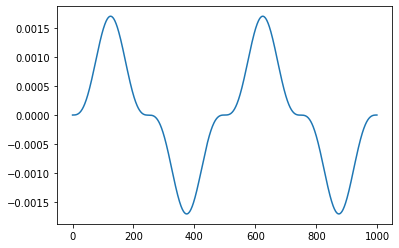

In [108]:
def fourier_sum(fundamental_period, amplitude_coefficients, dielectric_constants, t, x, N):
    n = np.arange(1, N+1)
    mode_angular_frequency = n*(1.0/fundamental_period)*2.0*pi
    temporal_phase = mode_angular_frequency * t
    spatial_phase = mode_angular_frequency*np.sqrt(mu_0*dielectric_constants*epsilon_0)*x
    
    
    pos = np.sum(amplitude_coefficients*np.cos(temporal_phase - spatial_phase), axis=0)
    neg = - np.sum(amplitude_coefficients*np.cos(temporal_phase - spatial_phase + fundamental_period/1000.0), axis=0)
    return pos + neg

N=3

amplitude_coefficients = fourier_amplitude_coefficients(2, 1, N) 

dielectric_constants = np.ones_like(amplitude_coefficients)

t = np.linspace(-2.0, 2.0, 1000)



dt = []
for i in t:
    dt.append(fourier_sum(2, amplitude_coefficients, dielectric_constants, i, 0, N))

plt.plot(dt)


In [109]:
def simple_dispersion(t, x, fundamental_period, N):

    n = np.arange(1, N+1)
    modes = (1.0/fundamental_period)*n
    dielectric_constants = np.zeros_like(modes, dtype=np.float)
    E_penetration_depths = np.zeros_like(modes, dtype=np.float)
    
    for idx,mode in enumerate(modes):
            
        cole_cole_properties = cole_cole_4(mode, ef, sigma, deltas, alphas, taus)
        dielectric_constant, conductivity = complex_permittivity_to_er_and_sigma(cole_cole_properties, mode)

        dielectric_constants[idx] = dielectric_constant
        E_penetration_depth = electric_field_penetration_depth(mode, dielectric_constant, conductivity)
        E_penetration_depths[idx] = E_penetration_depth


    return dielectric_constants, E_penetration_depths


t = 0
x = 0
fundamental_period = 1e-10
N = 5

spatial_wavenumbers, E_penetration_depths = simple_dispersion(t, x, fundamental_period, N)

spatial_wavenumbers

array([16.148587, 11.635295,  8.853361,  7.167008,  6.09477 ])

In [113]:
Winther (https://math.stackexchange.com/users/147873/winther), Integration and differentiation of Fourier series, URL (version: 2016-05-03): https://math.stackexchange.com/q/1770532

Fourier series' can't be simply differentiated. durn.

SyntaxError: invalid syntax (<ipython-input-113-50921c34582c>, line 1)

In [110]:

fundamental_period = (1/(10e9))
pulse_period = (1/(10e9))


t= 0
x = np.linspace(0, 0.05, 100)
t = np.linspace(-fundamental_period, fundamental_period, 100)


N = 8

# amplitude_coefficients = fourier_amplitude_coefficients(fundamental_period, pulse_period, N) 

dbm_coefficients = np.array([13, 5.1, 4, -0.1, -0.15, -9, -9.8, -12.5])

amplitude_coefficients = np.sqrt(((10.0**(dbm_coefficients/10.0))/1000.0)/377.0)

amplitude_coefficients /= amplitude_coefficients[0]


dielectric_constants, E_penetration_depths = simple_dispersion(t, x, fundamental_period, N)


# x_, t_, amplitude_coefficients = np.meshgrid(x, t, amplitude_coefficients)
# _, _, spatial_wavenumbers = np.meshgrid(x, t, spatial_wavenumbers)
# _, _, E_penetration_depths = np.meshgrid(x, t, E_penetration_depths)

# # amplitude_coefficients[0] = 0

dt = np.zeros((100, 100))

for ix,x_ in enumerate(x):
    for it, t_ in enumerate(t):
        amplitude_coefficients_ = amplitude_coefficients * np.exp(- x_ / E_penetration_depths)
        dt[it, ix] = fourier_sum(fundamental_period, amplitude_coefficients_, dielectric_constants, t_, x_, N)

no_dispersion = np.zeros((100, 100))
        
dielectric_constants = np.ones_like(dielectric_constants)

for ix,x_ in enumerate(x):
    for it, t_ in enumerate(t):
        amplitude_coefficients_ = amplitude_coefficients * np.exp(- x_ / E_penetration_depths)
        no_dispersion[it, ix] = fourier_sum(fundamental_period, amplitude_coefficients_, dielectric_constants, t_, x_, N)

        
# # t, x, amplitude_coefficients, spatial_wavenumbers, mode_phases = np.meshgrid(t, x, amplitude_coefficients, spatial_wavenumbers, mode_phases)




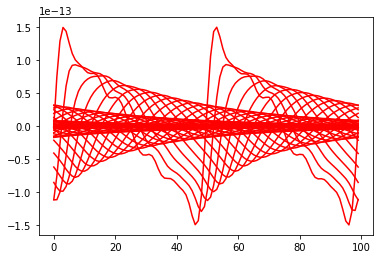

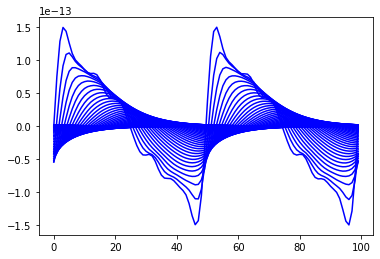

In [111]:

# for i in np.linspace(0, 0.05, 10):
plt.plot(dt, 'r')
plt.figure()
plt.plot(no_dispersion, 'b')

# plt.plot(dt[:, 0])
# plt.plot(no_dispersion[:, 0])

# plt.plot(dt[:, 50])
# plt.plot(no_dispersion[:, 50])

# plt.plot(dt[:, 50])
# plt.plot(dt[:, -1])

# plt.plot(dt[:, -1])

# plt.imshow(dt-no_dispersion,extent=(0,500,0,500))

# plt.xlabel("Distance")
# plt.ylabel("time")



6.6458205041572405e-18
6.705959843412296e-18


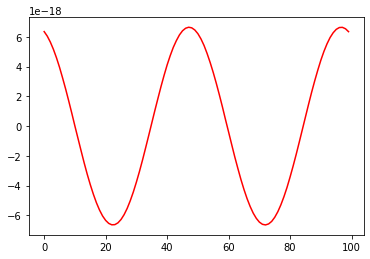

In [112]:
plt.plot(dt[:,99], 'r')

print(np.max(dt[:,99]))
print(np.max(no_dispersion[:,99]))